# **Projet Deep Learning - code**

METIN Samuel, TREMBLAY Marion, BERTRAND Flavie

Classification sur MNIST avec la restriction à 100 images annotées pour l'entraînement. Utilisation de la méthode de l'article "A Simple Framework for Contrastive Learning of Visual Representations" de Ting Chen, Simon Kornblith, Mohammad Norouzi et Geoffrey Hinton (Self Supervised Learning).

In [ ]:
import matplotlib.pyplot as plt # data plotting
import os
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset

random_state = 42
batch_size = 64
device = "cuda:0" if torch.cuda.is_available() else "cpu" # 0 indicates the GPU ID you will use
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
class UnlabeledDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, _ = self.subset[idx]  # on ignore le label ici
        return img

transform = transforms.Compose([
    transforms.ToTensor(),
])


dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train, val = train_test_split(dataset, test_size=10000, random_state=random_state)

# Unlabeled / Labeled Data
unlab_train, lab_train = train_test_split(train, test_size=100, random_state=random_state)

# Remove labels
unlab_train = UnlabeledDataset(unlab_train)

unlab_train_loader = DataLoader(unlab_train, batch_size=batch_size, shuffle=True)
lab_train_loader = DataLoader(lab_train, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

print("Train set (sans labels) : ", len(unlab_train))
print("Train set (avec labels) : ", len(lab_train))
print("Validation set : ", len(val))
print("Test set : ", len(test))

Train set (sans labels) :  49900
Train set (avec labels) :  100
Validation set :  10000
Test set :  10000


Apperçu des images (de test)

images.shape: torch.Size([64, 1, 28, 28])


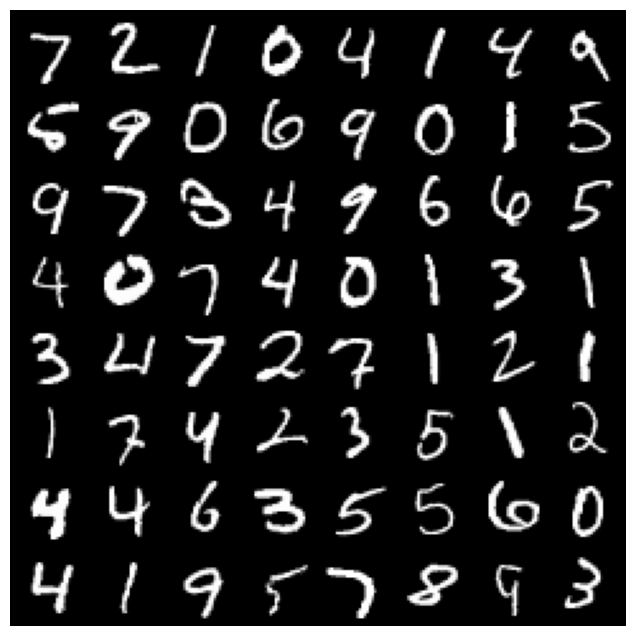

In [ ]:
from torchvision.utils import make_grid
for images, _ in test_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

### Architecture du CNN utilisé

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#height=7
#width=14

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dp1 = nn.Dropout(p=0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dp2 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.dp3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dp1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dp2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dp3(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model(net, epochs, train_loader, device=None, encoder=None, frozen=True):
    batch_size = 64

    if encoder is not None: # lorsqu'on fine-tune
        if frozen: # Pour le fine-tuning avec encodeur gelé
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # que les paramètres du classifieur
            encoder.eval()

        else: # Pour le fine-tuning complet
            optimizer = torch.optim.Adam(list(encoder.parameters()) + list(net.parameters()), lr=1e-3) # tous les paramètres
            encoder.train()
    else: # entrainement du modèle baseline
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    lst_train_loss = []

    for epoch in range(epochs):

        # TRAIN
        net.train()
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            if encoder is not None: # lorsqu'on fine-tune
                h = encoder(x)
                y_pred = net(x=h) # on classifie sur l'encodage

            else :
                y_pred = net(x=x)

            loss = criterion(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        lst_train_loss.append(train_loss)

    mean_train_loss = np.mean(lst_train_loss)

    #print("Train loss mean : ", mean_train_loss)
    return net


In [ ]:
def evaluate_model(net, test_loader, criterion, device, output_fn, encoder=None):
    net.eval()

    all_y_true = []
    all_y_pred = []

    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            if encoder is not None: # lorsqu'on fine-tune
                h = encoder(x)
                y_proba = output_fn(net(x=h))

            else:
                y_proba = output_fn(net(x=x))

            y_pred = y_proba.argmax(axis=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)

            all_y_true.append(y.cpu())
            all_y_pred.append(y_pred.cpu())

    test_acc = correct / total

    all_y_true = torch.cat(all_y_true)
    all_y_pred = torch.cat(all_y_pred)

    return test_acc, all_y_true, all_y_pred

Evaluation du modèle baseline avec 100 images + labels

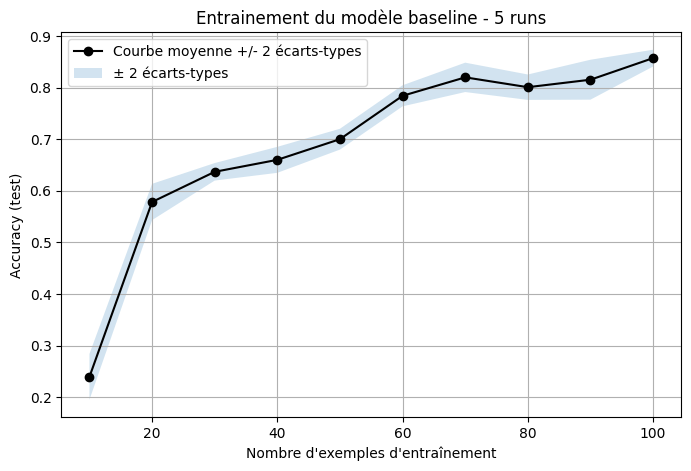

In [ ]:
sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
test_accuracies = []
n_repeats = 5

criterion = torch.nn.CrossEntropyLoss()
output_fn = torch.nn.Softmax(dim=1)

for i in range(n_repeats):
    accs=[]
    for n_samples in sizes:
        #print(f"\n=== Entraînement avec {n_samples} exemples ===")

        train_subset = Subset(lab_train, range(n_samples))
        train_loader = DataLoader(train_subset, batch_size=5, shuffle=True)

        net = Net().to(device)

        net = train_model(net, epochs=20, train_loader=train_loader, device=device)

        acc, y_true, y_pred = evaluate_model(net, test_loader, criterion, device, output_fn)
        accs.append(acc)

    # Stocker l’accuracy
    test_accuracies.append(accs)

# Calculer la moyenne et l'écart-type pour chaque taille
mean_acc = np.mean(test_accuracies, axis=0)
std_acc = np.std(test_accuracies, axis=0)

plt.figure(figsize=(8,5))
plt.plot(sizes, mean_acc, '-o', color='black', label='Courbe moyenne +/- 2 écarts-types')
plt.fill_between(sizes, mean_acc - 2 * std_acc, mean_acc + 2 * std_acc, alpha=0.2, label='± 2 écarts-types')
plt.title(f"Entrainement du modèle baseline - {n_repeats} runs")
plt.xlabel("Nombre d'exemples d'entraînement")
plt.ylabel("Accuracy (test)")
plt.legend()
plt.grid(True)
plt.show()

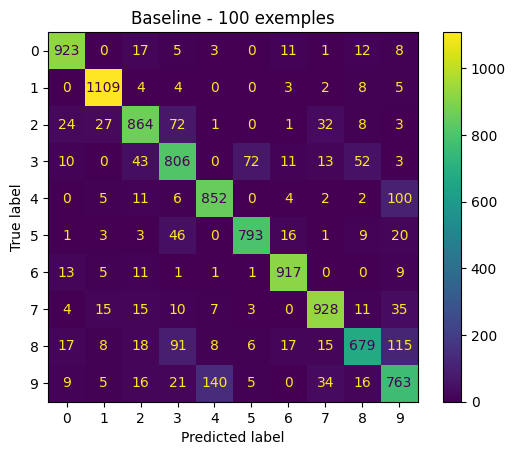

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.title("Baseline - 100 exemples")
plt.show()

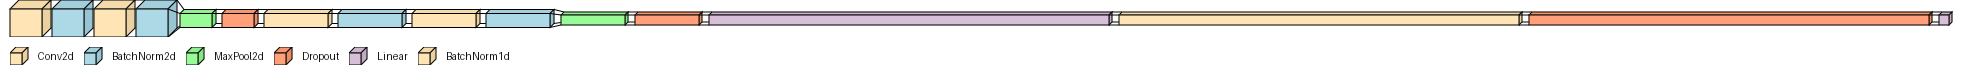

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─Conv2d: 1-3                            [1, 32, 28, 28]           9,248
├─BatchNorm2d: 1-4                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Dropout: 1-6                           [1, 32, 14, 14]           --
├─Conv2d: 1-7                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 14, 14]           128
├─Conv2d: 1-9                            [1, 64, 14, 14]           36,928
├─BatchNorm2d: 1-10                      [1, 64, 14, 14]           128
├─MaxPool2d: 1-11                        [1, 64, 7, 7]             --
├─Dropout: 1-12                          [1, 64, 7, 7]             --
├

In [73]:
#!pip install visualtorch
import visualtorch
net_cpu = net.to("cpu")
img=visualtorch.layered_view(
    net_cpu,
    input_shape=(1, 1, 28, 28),
    legend=True,
    scale_xy=1,
    scale_z=1,
)
display(img)
net = net_cpu.to(device)

#!pip install torchinfo
from torchinfo import summary
summary(net, input_size=(1,1,28,28))

# SimCLR method

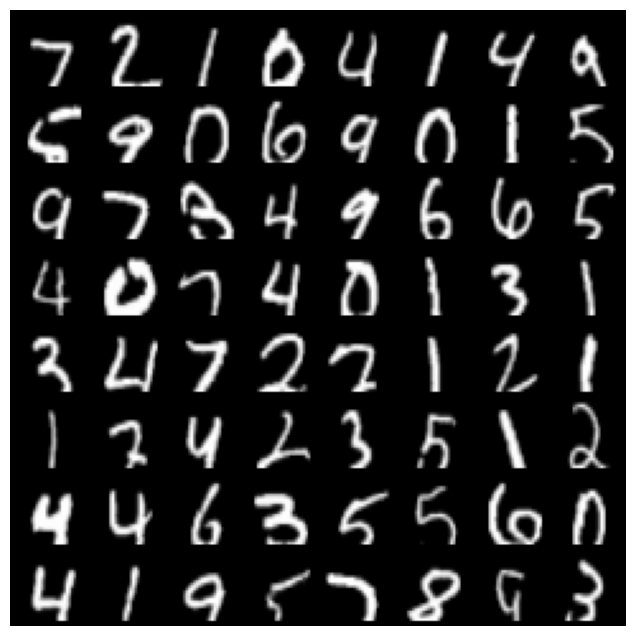

In [ ]:
# transformations
augmentation = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(28, scale=(0.7, 0.7)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=9)], p=1),
])

# Apperçu des transformations
for images, _ in test_loader:
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(augmentation(images), nrow=8).permute((1, 2, 0)))
    break

In [ ]:
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        x = self.dataset[idx] # image without label
        x1 = self.transform(x)
        x2 = self.transform(x)
        return x1, x2

    def __len__(self):
        return len(self.dataset)

In [ ]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super().__init__()
        self.encoder = base_model
        self.encoder.fc2 = nn.Identity()  # retirer la couche de classification

        # MLP projecteur
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)

In [ ]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)

    # Compute all pairwise cosine similarities (2*batch_size, 2*batch_size)
    all_sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

    # Extract positive pairs (2*batch_size,)
    positives = torch.cat([torch.diag(all_sim, batch_size),
                           torch.diag(all_sim, -batch_size)], dim=0)

    # Mask for self-similarities (used for denominator)
    self_mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)

    # Similarities excluding self-similarity (2*batch_size, 2*batch_size - 1)
    sim_excluding_self = all_sim[~self_mask].view(2 * batch_size, -1)

    # Numerator: exp(positives / temperature) (2*batch_size,)
    numerator = torch.exp(positives / temperature)

    # Denominator: sum of exp(similarities_excluding_self / temperature) along dimension 1 (2*batch_size,)
    denominator = torch.sum(torch.exp(sim_excluding_self / temperature), dim=1)

    loss = -torch.log(numerator / denominator)
    return loss.mean()

Entraînement non-supervisé de l'encodeur

Epoch 1/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Epoch [1/20] | Train loss: 5.7678 | Val loss: 5.4340


Epoch 2/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch [2/20] | Train loss: 5.4680 | Val loss: 5.3187


Epoch 3/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch [3/20] | Train loss: 5.3861 | Val loss: 5.2645


Epoch 4/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch [4/20] | Train loss: 5.3426 | Val loss: 5.2594


Epoch 5/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch [5/20] | Train loss: 5.3175 | Val loss: 5.2259


Epoch 6/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch [6/20] | Train loss: 5.2929 | Val loss: 5.2015


Epoch 7/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Epoch [7/20] | Train loss: 5.2748 | Val loss: 5.1906


Epoch 8/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Epoch [8/20] | Train loss: 5.2596 | Val loss: 5.1681


Epoch 9/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch [9/20] | Train loss: 5.2455 | Val loss: 5.1577


Epoch 10/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch [10/20] | Train loss: 5.2328 | Val loss: 5.1444


Epoch 11/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch [11/20] | Train loss: 5.2206 | Val loss: 5.1318


Epoch 12/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch [12/20] | Train loss: 5.2111 | Val loss: 5.1382


Epoch 13/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Epoch [13/20] | Train loss: 5.2043 | Val loss: 5.1172


Epoch 14/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch [14/20] | Train loss: 5.1969 | Val loss: 5.1182


Epoch 15/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch [15/20] | Train loss: 5.1903 | Val loss: 5.1100


Epoch 16/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch [16/20] | Train loss: 5.1852 | Val loss: 5.1087


Epoch 17/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch [17/20] | Train loss: 5.1806 | Val loss: 5.1030


Epoch 18/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.18it/s]


Epoch [18/20] | Train loss: 5.1761 | Val loss: 5.0976


Epoch 19/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Epoch [19/20] | Train loss: 5.1743 | Val loss: 5.0948


Epoch 20/20 [Val]: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch [20/20] | Train loss: 5.1671 | Val loss: 5.0906


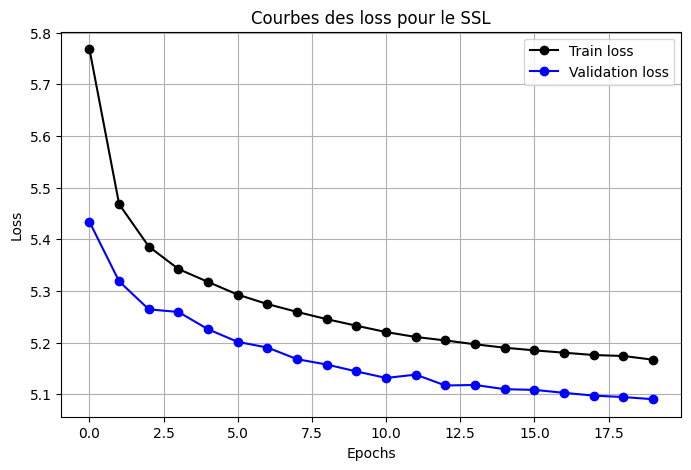

In [ ]:
model = SimCLR(Net()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 512

train_augm = SimCLRDataset(dataset=unlab_train, transform=augmentation)
train_augm_loader = DataLoader(train_augm, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

unlab_val = UnlabeledDataset(val)
val_augm = SimCLRDataset(dataset=unlab_val, transform=augmentation)
val_augm_loader = DataLoader(val_augm, batch_size=batch_size, shuffle=False, num_workers=4)

temperature = 0.5
epochs = 20

lst_train_loss = []
lst_val_loss = []

for epoch in range(epochs):

    # TRAIN
    model.train()
    train_loss = 0.0

    train_pbar = tqdm(train_augm_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

    for x1, x2 in train_pbar:
        z1 = model(x1.to(device))
        z2 = model(x2.to(device))

        loss = nt_xent_loss(z1, z2, temperature)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_augm_loader)
    lst_train_loss.append(train_loss)

    # VALIDATION
    model.eval()
    val_loss = 0.0

    val_pbar = tqdm(val_augm_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')

    with torch.no_grad():
        for x1, x2 in val_pbar:

            z1 = model(x1.to(device))
            z2 = model(x2.to(device))

            loss = nt_xent_loss(z1, z2, temperature)
            val_loss += loss.item()

    val_loss /= len(val_augm_loader)
    lst_val_loss.append(val_loss)

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f}"
    )

plt.figure(figsize=(8,5))
plt.plot(list(range(epochs)), lst_train_loss, '-o', color='black', label='Train loss')
plt.plot(list(range(epochs)), lst_val_loss, '-o', color='blue', label='Validation loss')
plt.title("Courbes des loss pour le SSL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim=512, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

Fine-tuning encodeur gelé

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False


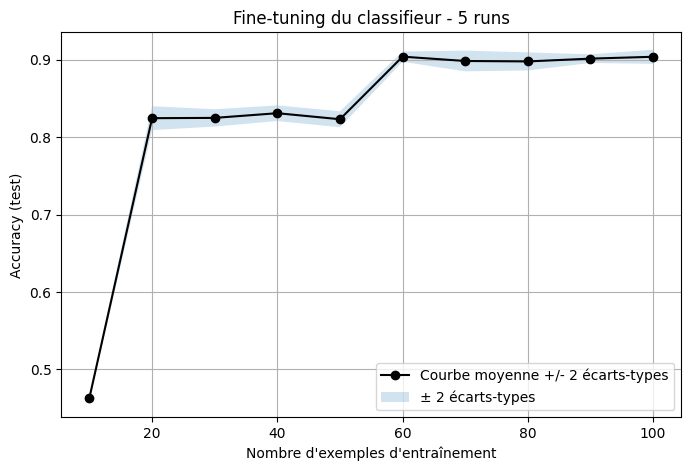

In [ ]:
sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_repeats = 5

test_accuracies = []

criterion = torch.nn.CrossEntropyLoss()
output_fn = torch.nn.Softmax(dim=1)

for i in range(n_repeats):
    accs=[]
    #print("Exécution : ", i)
    for n_samples in sizes:
        #print(f"\n=== Entraînement avec {n_samples} exemples ===")

        train_subset = Subset(lab_train, range(n_samples))
        train_loader = DataLoader(train_subset, batch_size=5, shuffle=True)

        classifier = LinearClassifier().to(device)

        classifier = train_model(classifier, epochs=20, train_loader=train_loader,
                                 device=device, encoder=model.encoder, frozen=True)

        acc, y_true, y_pred = evaluate_model(classifier, test_loader, criterion, device, output_fn, encoder=model.encoder)
        accs.append(acc)

    # Stocker l’accuracy
    test_accuracies.append(accs)

# Calculer la moyenne et l'écart-type pour chaque taille
mean_acc = np.mean(test_accuracies, axis=0)
std_acc = np.std(test_accuracies, axis=0)

plt.figure(figsize=(8,5))
plt.plot(sizes, mean_acc, '-o', color='black', label='Courbe moyenne +/- 2 écarts-types')
plt.fill_between(sizes, mean_acc - 2 * std_acc, mean_acc + 2 * std_acc, alpha=0.2, label='± 2 écarts-types')
plt.title(f"Fine-tuning du classifieur - {n_repeats} runs")
plt.xlabel("Nombre d'exemples d'entraînement")
plt.ylabel("Accuracy (test)")
plt.legend()
plt.grid(True)
plt.show()

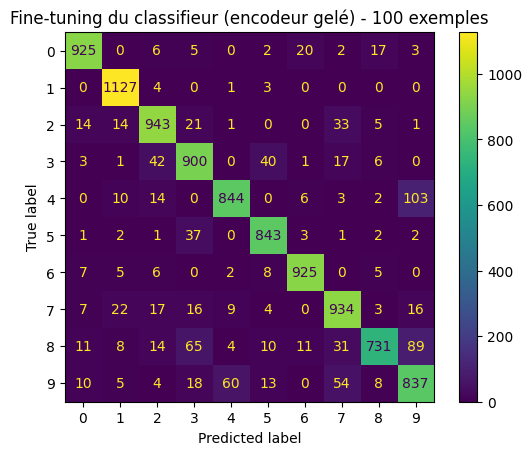

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.title("Fine-tuning du classifieur (encodeur gelé) - 100 exemples")
plt.show()

In [ ]:
# Vérification que l'encoder était bien gelé pendant le fine-tuning

for name, p in model.encoder.named_parameters():
    print(name, p.requires_grad)

conv1.weight False
conv1.bias False
bn1.weight False
bn1.bias False
conv2.weight False
conv2.bias False
bn2.weight False
bn2.bias False
conv3.weight False
conv3.bias False
bn3.weight False
bn3.bias False
conv4.weight False
conv4.bias False
bn4.weight False
bn4.bias False
fc1.weight False
fc1.bias False
bn_fc.weight False
bn_fc.bias False


Fine-tuning encodeur dégelé

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = True

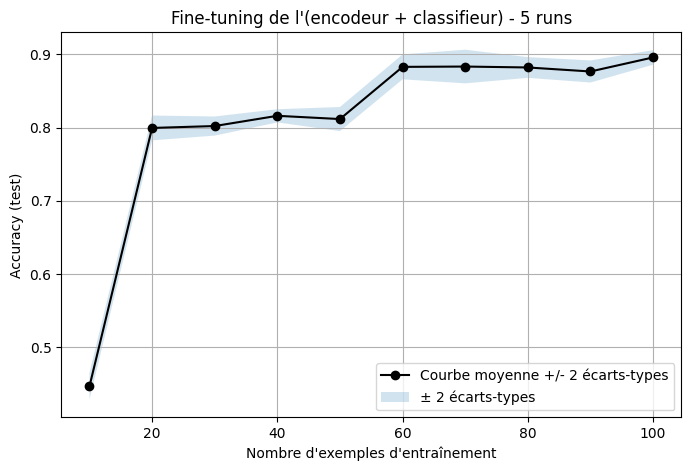

In [ ]:
sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_repeats = 5

test_accuracies = []

criterion = torch.nn.CrossEntropyLoss()
output_fn = torch.nn.Softmax(dim=1)

for i in range(n_repeats):
    accs=[]
    #print("Exécution : ", i)
    for n_samples in sizes:
        #print(f"\n=== Entraînement avec {n_samples} exemples ===")

        train_subset = Subset(lab_train, range(n_samples))
        train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)

        classifier = LinearClassifier().to(device)

        classifier = train_model(classifier, epochs=20, train_loader=train_loader,
                                 device=device, encoder=model.encoder, frozen=False)

        acc, y_true, y_pred = evaluate_model(classifier, test_loader, criterion, device, output_fn, encoder=model.encoder)
        accs.append(acc)

    # Stocker l’accuracy
    test_accuracies.append(accs)

# Calculer la moyenne et l'écart-type pour chaque taille
mean_acc = np.mean(test_accuracies, axis=0)
std_acc = np.std(test_accuracies, axis=0)

plt.figure(figsize=(8,5))
plt.plot(sizes, mean_acc, '-o', color='black', label='Courbe moyenne +/- 2 écarts-types')
plt.fill_between(sizes, mean_acc - 2 * std_acc, mean_acc + 2 * std_acc, alpha=0.2, label='± 2 écarts-types')
plt.title(f"Fine-tuning de l'(encodeur + classifieur) - {n_repeats} runs")
plt.xlabel("Nombre d'exemples d'entraînement")
plt.ylabel("Accuracy (test)")
plt.legend()
plt.grid(True)
plt.show()

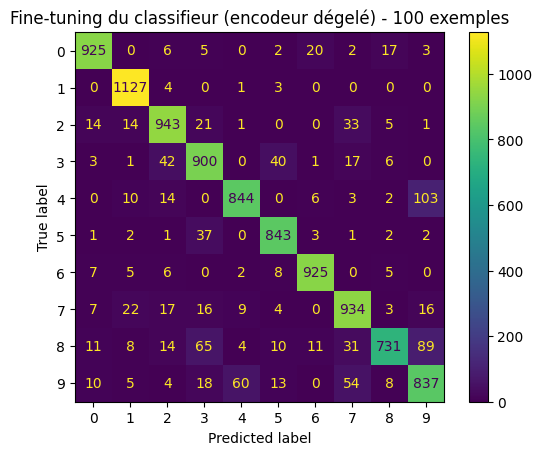

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.title("Fine-tuning du classifieur (encodeur dégelé) - 100 exemples")
plt.show()